# Monitor de notícias de jogadores de futebol - Campeonato Brasileiro Série A 2025

## Introdução

No universo dos esportes, a informação é um ativo valioso. A cobertura de notícias exerce forte influência na percepção do público, impacta diretamente nos valores de mercado dos jogadores e no engajamento dos torcedores. Com o avanço das redes sociais e plataformas digitais, a difusão de informações tornou-se ainda mais rápida e abrangente. No contexto do futebol brasileiro, não é diferente. A todo momento, surgem novas notícias sobre jogadores, clubes e competições, principalmente referentes aos times que disputam a primeira divisão (Série A), gerando um volume massivo de conteúdo que dificulta filtrar e identificar os temas mais relevantes. Diante desse panorama, torna-se imprescindível adotar métodos mais precisos de coleta e análise de notícias para extrair insights estratégicos.

## Problema

O fluxo intenso de publicações esportivas gera dois grandes desafios:
- **Ruído de informação**: a quantidade excessiva de notícias torna difícil identificar quais são as mais relevantes e impactantes para cada clube, ou até de distinguir notícias verdadeiras de boatos.
- **Escalabilidade**: a curadoria manual de notícias é trabalhosa e ineficiente, especialmente quando se trata de acompanhar múltiplos clubes e jogadores ao mesmo tempo, além de ser sujeita a vieses e impossível de ser mantida em larga escala.

Logo, a ausência de uma ferramenta que sistematicamente colete, analise e exiba as notícias e tópicos mais relevantes, gestores e analistas perdem tempo e correm maior risco de tomar decisões baseadas em informações incompletas ou enviesadas, podendo levar a interpretações erradas sobre o desempenho dos clubes, influenciar negativamente a imagem dos jogadores e afetar o engajamento dos torcedores.

## Solução proposta

A proposta deste projeto é desenvolver um monitor de notícias focado no Campeonato Brasileiro Série A 2025, que permita a coleta, análise e visualização de informações sobre os clubes envolvidos nesta competição. Para isso, serão utilizadas técnicas de web scraping para extrair as notícias mais recentes e relevantes dos times participantes do campeonato, e com isso, a criação de nuvens de palavras que representem os principais tópicos abordados nas notícias sobre cada clube.

Além disso, com o auxílio de LLM (Large Language Models), será possível realizar uma análise mais aprofundada do conteúdo das notícias, identificando o sentimento geral que cada notícia transmite, se é positivo, negativo ou neutro. Isso permitirá uma compreensão mais clara de como os clubes e jogadores estão sendo percebidos pela mídia e pelo público em geral.




## Configuração do Ambiente e Instalação de Dependências

Este notebook utiliza Python e requer a criação de um ambiente virtual para garantir a consistência das dependências. Execute os comandos abaixo no terminal para configurar o ambiente:

```bash
python -m venv venv
source venv/bin/activate  # No Windows: venv\Scripts\activate
pip install --upgrade pip
pip install -r requirements.txt
```

O arquivo `requirements.txt` deve conter todas as bibliotecas necessárias para rodar este notebook.


Em seguida, importe as bibliotecas necessárias para o projeto:

In [23]:
import os
import re
import math

import requests
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

import pandas as pd

import wordcloud
import matplotlib.pyplot as plt
from IPython.display import display

from dotenv import load_dotenv

import google.generativeai as genai
from google.generativeai import GenerationConfig


## Definição das funções auxiliares

Para realizar a coleta das notícias, é necessário definir algumas funções auxiliares que serão responsáveis por buscar as informações (web scraping) e processar os dados coletados.

Função para obter o HTML da página a ser acessada para extração dos dados

In [24]:
def baixar_pagina(url):
    """
    Faz uma requisição HTTP GET para a URL fornecida e retorna o conteúdo HTML da página.

    Parâmetros:
    url (str): Endereço da página a ser baixada.

    Retorna:
    str: Conteúdo HTML da página como texto decodificado em UTF-8.
    """
    response = requests.get(url)
    response.encoding = "utf-8"
    return response.text

Função responsável por obter o link de uma notícia contido em seu respectivo título

In [25]:
def extrair_links_noticias_post(url):
    """
    Extrai os links de notícias de um post de página HTML.

    Parâmetros:
    url (str): URL da página a partir da qual serão extraídos os links.

    Retorna:
    List[str]: Lista de URLs obtidas dos elementos <h2><a> encontrados na página.
    """
    html = baixar_pagina(url)
    soup = BeautifulSoup(html, 'html.parser')
    titulos = soup.find_all('h2')
    links_noticias = []
    for titulo in titulos:
        a_tag = titulo.find('a')
        if a_tag and a_tag.get('href'):
            links_noticias.append(a_tag.get('href'))
    return links_noticias


Função para extrair o conteúdo de cada notícia

In [26]:
def extrair_conteudo_noticia(url):
    """
    Extrai o conteúdo textual de uma notícia a partir da URL fornecida,
    filtrando parágrafos relevantes e descartando intertítulos e listas.

    Parâmetros:
    url (str): Endereço da página da notícia a ser processada.

    Retorna:
    List[str]: Lista de strings contendo o texto limpo de cada parágrafo
               (<p> com classe 'content-text__container') sem intertítulos
               (div com classe 'content-intertitle') nem listas (<ul>).
    """
    html = baixar_pagina(url)
    soup = BeautifulSoup(html, 'html.parser')
    ps = soup.find_all('p', class_='content-text__container')

    textos = []
    for p in ps:
        if p.find('div', class_='content-intertitle') or p.find('ul'):
            continue
        textos.append(p.get_text(" ", strip=True))
    return textos

Após a definição das funções necessárias para a extração de dados, podemos aplicá-las para realizar a extração

O site escolhido para a obtenção de notícias foi o **Globo Esporte** (https://ge.globo.com/)

In [27]:
times = ["atletico-mg", "bahia", "botafogo", "bragantino", "ceara", "corinthians", "cruzeiro", "flamengo", "fluminense", "fortaleza",
         "gremio", "internacional", "juventude", "mirassol", "palmeiras", "santos", "sao-paulo", "sport", "vasco", "vitoria"]

conteudos_times = {}

In [28]:
base_url = "https://ge.globo.com/futebol/times/"

for t in times:
    time_url = base_url + t  # URL completa da página do time
    noticias = extrair_links_noticias_post(time_url)  # links dos posts de notícia

    conteudos = []
    for n in noticias:
        if not n.startswith("https://ge.globo.com/"):
            continue
        conteudos.append(extrair_conteudo_noticia(n))

    pattern = re.compile(r'^\+ O ge')
    c = [
        " ".join(parts)
        for parts in conteudos
        if not pattern.match(" ".join(parts))
    ]

    c = [texto for texto in c if texto.strip()]

    conteudos_times[t] = c


In [29]:
records = [
    (time, noticia)
    for time, noticias in conteudos_times.items()
    for noticia in noticias
]

df_time_noticia = pd.DataFrame(records, columns=['time', 'noticia'])


Para verificarmos se a extração foi feita corretamente, vamos exibir o DataFrame construído com os times e suas respectivas notícias.

In [30]:
df_time_noticia

time  \
0   atletico-mg   
1   atletico-mg   
2   atletico-mg   
3   atletico-mg   
4   atletico-mg   
..          ...   
89      vitoria   
90      vitoria   
91      vitoria   
92      vitoria   
93      vitoria   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                noticia  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Após a validação do DataFrame, podemos salvar estas informações dentro de um arquivo .csv no diretório /data

In [31]:
if not os.path.exists('./data'):
    os.makedirs('./data')

In [32]:
df_time_noticia.to_csv("./data/times_noticias.csv")

### Nuvem de Palavras por Time

Esta célula gera nuvens de palavras para cada time de forma resumida:

1. **Stopwords:** Carrega stopwords em português e inclui variações do nome do time e termos comuns de notícias.
2. **Limpeza:** Filtra essas stopwords do texto consolidado de cada time.
3. **Geração:** Cria e plota `WordCloud` (800×400) em um grid com 2 colunas.
4. **Exibição:** Ajusta o layout, esconde eixos extras e exibe as nuvens.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


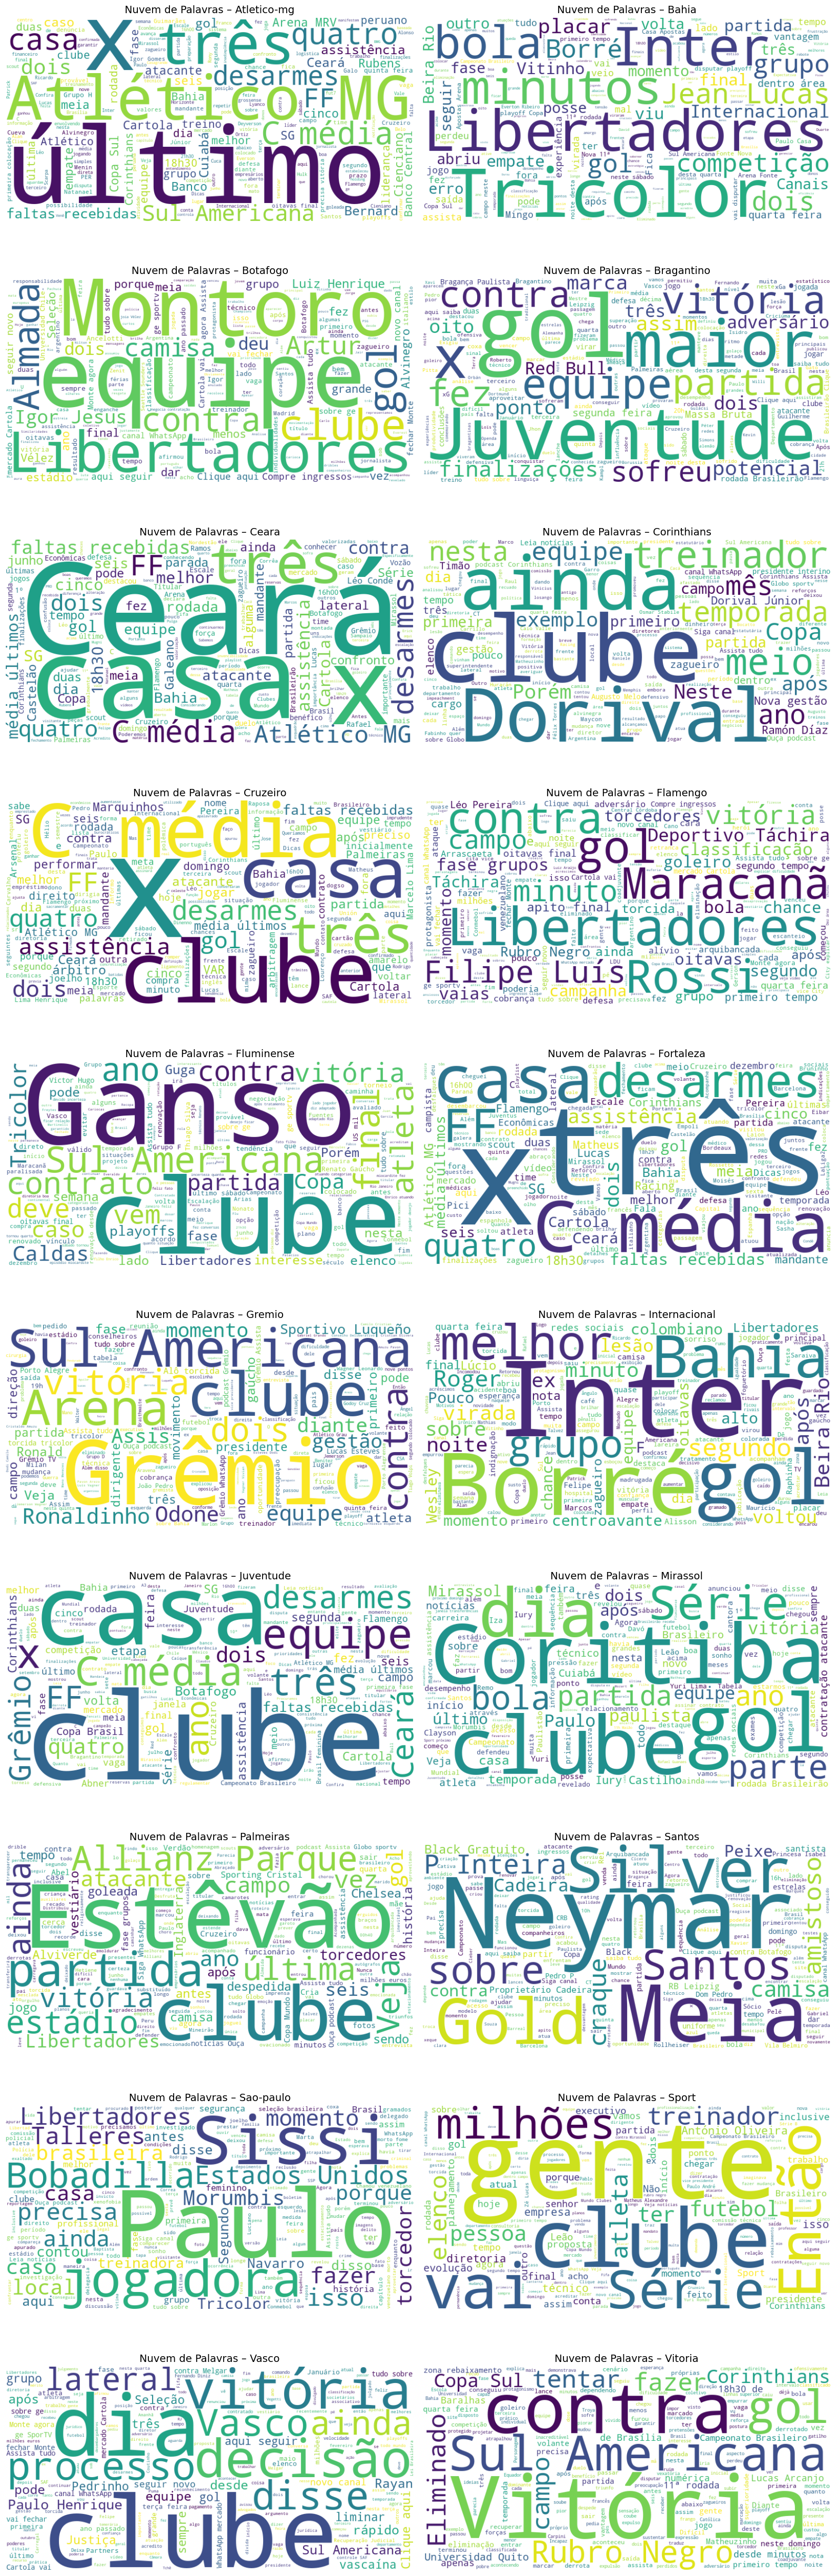

In [33]:
nltk.download('stopwords')

def gerar_nuvens_por_time(conteudos_times):
    """
    Gera e exibe nuvens de palavras para cada time.

    - Filtra stopwords em português e variações do nome do time.
    - Remove termos comuns de notícia e futebol.
    - Plota as nuvens em um grid de 2 colunas.

    Args:
        conteudos_times (dict): mapeia nome do time (str) para lista de textos (List[str]).
    """
    stop_words_base = set(stopwords.words('portuguese'))

    teams = list(conteudos_times.keys())
    cols = 2
    rows = math.ceil(len(teams) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
    axes = axes.flatten()

    for idx, time in enumerate(teams):
        # Une todos os textos do time em uma única string
        texto = " ".join(conteudos_times[time])

        extras = {time, time.replace('-', ''), time.replace('-', ' ')}
        stop_words = stop_words_base.union(w.lower() for w in extras)
        stop_words.update([
            'ge', 'g1', 'globo', 'globoesporte', 'futebol',
            'brasileirao', 'brasileirão', 'notícia', 'noticias',
            'jogo', 'jogos', 'time', 'times', 'jogador', 'jogadores'
        ])

        # Filtra palavras indesejadas
        palavras = [w for w in texto.split() if w.lower() not in stop_words]
        texto_limpo = " ".join(palavras)

        # Gera a nuvem de palavras
        wc = wordcloud.WordCloud(width=800, height=400, background_color='white')
        wc.generate(texto_limpo)

        # Exibe a nuvem
        ax = axes[idx]
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Nuvem de Palavras – {time.capitalize()}', fontsize=14)

    # Desliga eixos extras se houver subplots sobrando
    for ax in axes[len(teams):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Executa a geração de nuvens
gerar_nuvens_por_time(conteudos_times)


Com os plots das nuvens de palavras agora gerados, é possível visualizar os principais tópicos abordados nas notícias de cada clube, onde as palavras mais frequentes aparecem em destaque, permitindo uma análise rápida dos temas mais recorrentes nas notícias de cada time.

# Análise de Sentimento via Few-Shot com Gemini

### Configuração do Gemini e Técnica de Few-Shot Learning

Para usar o modelo Gemini, é necessário criar um arquivo `.env` na raiz do projeto contendo sua chave de API:

```
GEMINI_API_KEY=your_api_key_here
```

Este parte do notebook utiliza a técnica de *few-shot learning* para classificação de sentimento. A abordagem consiste em:

1. **Exemplos de Apoio**: Carregar um CSV (`few_shot_examples.csv`) com alguns exemplos rotulados de texto e sentimento.
2. **Construção do Prompt**: Combinar os exemplos de apoio com os novos textos a serem classificados em um único prompt.
3. **Chamada à LLM**: Enviar o prompt ao modelo Gemini para que ele aprenda, a partir dos exemplos, como classificar o sentimento dos novos textos.
4. **Interpretação da Resposta**: O modelo retorna uma lista de pares `ID: SENTIMENTO`, que é então mapeada de volta ao DataFrame original.

Essa técnica permite orientar o modelo com exemplos personalizados sem a necessidade de treinar um novo modelo do zero.


Dado que não possuímos uma quantidade de dados suficiente para treinar um modelo de aprendizado de máquina do zero eficiente, a técnica de *few-shot learning* é uma abordagem eficaz para adaptar o modelo Gemini às nossas necessidades específicas de análise de sentimentos.

In [41]:
load_dotenv()

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

csv_path = './data/times_noticias.csv'

df = pd.read_csv(csv_path)
df['sentiment'] = df.get('sentiment', None)

Para a construção do prompt, utilizamos exemplos de apoio que contêm textos e seus respectivos sentimentos. Esses exemplos são combinados com os novos textos a serem classificados, formando um prompt que guia o modelo na tarefa de classificação.

In [48]:
example_df = pd.read_csv('./data/few_shot_examples.csv')  # colunas: id, noticia, sentiment

if 'Unnamed: 0' in df.columns:
    df = df.rename(columns={'Unnamed: 0': 'id'})
if 'id' not in df.columns:
    df['id'] = df.index

# Constrói o bloco de exemplos few-shot
few_shot = ""
for _, ex in example_df.iterrows():
    eid, text, label = ex['id'], ex['noticia'], ex['sentiment']
    few_shot += f'Texto (ID {eid}): "{text}"\nSentimento: {label}\n\n'

# Seleciona somente as notícias que serão classificadas (exclui exemplos few-shot)
batch_items = df[~df['id'].isin(example_df['id'])]

# Prepara a lista de itens no formato "ID: \"noticia\""
batch_list = "\n".join(
    f"{row['id']}: \"{row['noticia']}\""
    for _, row in batch_items.iterrows()
)

# Monta o prompt completo para enviar ao modelo
batch_prompt = (
    few_shot
    + "Agora, para cada um dos textos abaixo, identifique o sentimento como 'positive', 'neutral' ou 'negative'.\n"
    + "Responda em formato de lista, uma linha por item, no formato:\n"
    + "ID: SENTIMENTO\n\n"
    + batch_list
)


Configurando o modelo Gemini

In [49]:
generation_config = GenerationConfig(
    max_output_tokens=len(batch_items) * 5,  # define limite de tokens com base na quantidade de itens
    temperature=0.0                          # temperatura zero garante saída determinística
)

response = model.generate_content(
    batch_prompt,
    generation_config=generation_config
)


Salvando o DataFrame com as classificações de sentimento

In [52]:
mapping = {}

for line in response.text.splitlines():
    match = re.match(
        r'^\s*(\d+)\s*[:\-]\s*(positive|neutral|negative)',
        line.strip(),
        re.IGNORECASE
    )
    if match:
        item_id = int(match.group(1))
        sentiment = match.group(2).lower()
        mapping[item_id] = sentiment

for eid, sentiment in mapping.items():
    df.loc[df['id'] == eid, 'sentiment'] = sentiment

output_path = './data/times_noticias_classified.csv'
df.to_csv(output_path, index=False)
print(f"Classificação salva em: {output_path}")


Classificação salva em: ./data/times_noticias_classified.csv


Exibindo a distribuição de sentimentos entre as notícias 

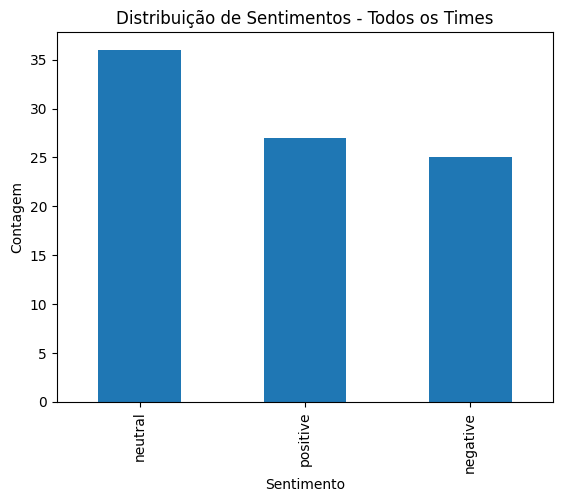

In [53]:
sentiment_counts = df['sentiment'].value_counts()

sentiment_counts.plot(
    kind='bar',
    title='Distribuição de Sentimentos - Todos os Times',
)

plt.xlabel('Sentimento')
plt.ylabel('Contagem')

plt.show()


Com essa ferramenta, agora também se torna possível analisar a distribuição de sentimentos entre as notícias de cada time. Essa análise pode ser extremamente valiosa para gestores, analistas e torcedores, pois fornece uma visão mais clara sobre como os times estão sendo percebidos pela mídia e pelo público em geral.

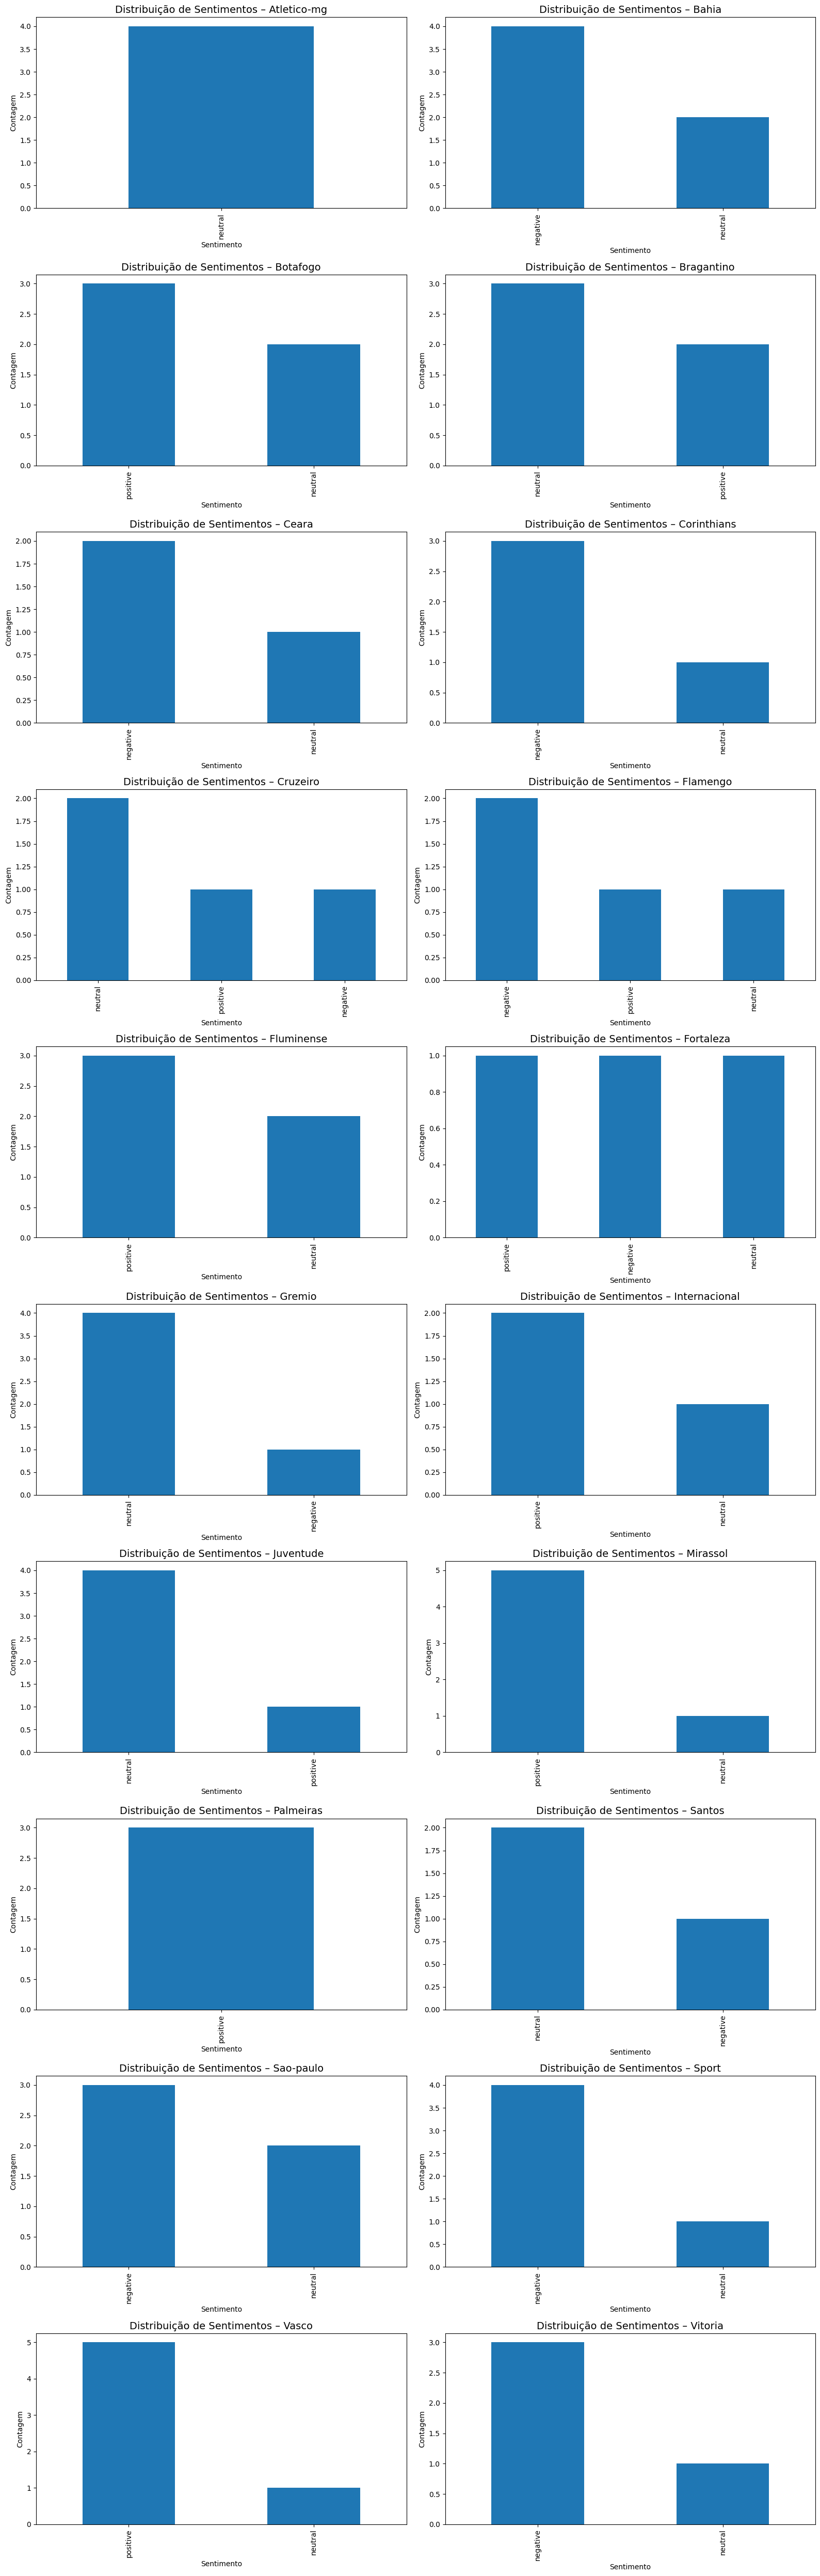

In [39]:
def plotar_distribuicao_sentimentos_por_time(df):
    """
    Plota a distribuição de sentimentos para cada time em subplots.

    Args:
        df (pd.DataFrame): DataFrame contendo colunas 'time' e 'sentiment'.
    """
    times = df['time'].unique()
    cols = 2
    rows = math.ceil(len(times) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
    axes = axes.flatten()

    for idx, time in enumerate(times):
        subset = df[df['time'] == time]
        sentiment_counts = subset['sentiment'].value_counts()

        ax = axes[idx]
        sentiment_counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Distribuição de Sentimentos – {time.capitalize()}', fontsize=14)
        ax.set_xlabel('Sentimento')
        ax.set_ylabel('Contagem')

    # Desliga eixos extras se houver subplots sobrando
    for ax in axes[len(times):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
# Executa a plotagem da distribuição de sentimentos por time
plotar_distribuicao_sentimentos_por_time(df)

### Conclusão

Neste projeto foi desenvolvido um fluxo completo de coleta de notícias sobre os clubes do Campeonato Brasileiro Série A 2025 utilizando técnicas de web scraping, exibição de nuvens de palavras com o objetivo de evidenciar os principais tópicos abordados nas notícias de cada clube, e a realização de uma análise de sentimento por meio de um modelo LLM (Large Language Model) para identificar o sentimento geral transmitido pelas notícias sobre cada time.

Vale ressaltar novamente que, devido à quantidade de dados disponíveis após a extração, a criação de um modelo de aprendizado de máquina do zero para classificação de sentimentos não se viu como uma opção viável neste momento, pois requer um volume maior de dados rotulados para que o modelo pudesse entregar resultados confiáveis. Em vez disso, optamos por utilizar a técnica de *few-shot learning* com o modelo Gemini, que é um modelo pré-treinado, permitindo que possamos aproveitar seu conhecimento prévio e adaptá-lo à nossa tarefa específica de classificação de sentimentos com um número reduzido de exemplos rotulados.